In [1]:
from keras.preprocessing import  sequence
from keras.datasets import imdb
from matplotlib import pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
from keras import backend as K
from keras.engine.topology import Layer

In [20]:
class Self_Attention(Layer):
    def __init__(self,output_dim,**kwargs):
        self.output_dim=output_dim
        super(Self_Attention,self).__init__(**kwargs)
    def build(self,input_shape):
        #为该层创建一个可训练的权重
        #Iinput.shape=(batch_size,time_steps,seq_len)
        self.kernel=self.add_weight(name='kernel',shape=(3,input_shape[2],self.output_dim),
                                   initializer='uniform',trainable=True)
        super(Self_Attention,self).build(input_shape)#最后调用
    def call (self,x):
        WQ=K.dot(x,self.kernel[0])
        WK=K.dot(x,self.kernel[1])
        WV=K.dot(x,self.kernel[2])
        
        print("WQ.shape",WQ.shape)
        print("K.permute_dimensions(WK, [0, 2, 1]).shape",K.permute_dimensions(WK, [0, 2, 1]).shape)
        QK = K.batch_dot(WQ,K.permute_dimensions(WK, [0, 2, 1]))
        QK = QK / (self.output_dim**0.5)###*******
        QK = K.softmax(QK)
        print("QK.shape",QK.shape)
        V = K.batch_dot(QK,WV)
        return V
    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[1],self.output_dim)
    

    print('Loading data...')
    

Loading data...


In [21]:
#标签转化为独热码
max_features = 20000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
y_train, y_test = pd.get_dummies(y_train),pd.get_dummies(y_test)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

#数据归一化处理
maxlen = 64
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
#%%


25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 64)
x_test shape: (25000, 64)


In [22]:
batch_size = 32
from keras.models import Model
from keras.optimizers import SGD,Adam
from keras.layers import *
S_inputs = Input(shape=(64,), dtype='int32')
embeddings = Embedding(max_features, 128)(S_inputs)
O_seq = Self_Attention(128)(embeddings)
O_seq = GlobalAveragePooling1D()(O_seq)
O_seq = Dropout(0.5)(O_seq)
outputs = Dense(2, activation='softmax')(O_seq)
model = Model(inputs=S_inputs, outputs=outputs)
print(model.summary())
# try using different optimizers and different optimizer configs
opt = Adam(lr=0.0002,decay=0.00001)
loss = 'categorical_crossentropy'
model.compile(loss=loss,

             optimizer=opt,

             metrics=['accuracy'])
print('Train...')

WQ.shape (?, 64, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (?, 128, 64)
QK.shape (?, 64, 64)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 64)                0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 64, 128)           2560000   
_________________________________________________________________
self__attention_4 (Self_Atte (None, 64, 128)           49152     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,609,410
Trainable params: 2,

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 17s 692us/step - loss: 0.5266 - acc: 0.7504 - val_loss: 0.3840 - val_acc: 0.8274
Epoch 2/5
25000/25000 [==============================] - 5s 200us/step - loss: 0.3258 - acc: 0.8590 - val_loss: 0.3689 - val_acc: 0.8362
Epoch 3/5
25000/25000 [==============================] - 5s 200us/step - loss: 0.2609 - acc: 0.8940 - val_loss: 0.3896 - val_acc: 0.8304
Epoch 4/5
25000/25000 [==============================] - 5s 200us/step - loss: 0.2093 - acc: 0.9175 - val_loss: 0.4443 - val_acc: 0.8224
Epoch 5/5
25000/25000 [==============================] - 5s 201us/step - loss: 0.1662 - acc: 0.9361 - val_loss: 0.5243 - val_acc: 0.8112


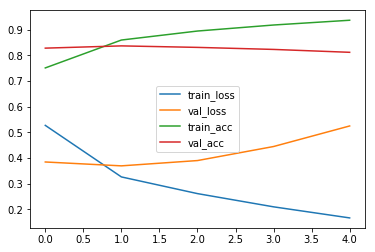

In [23]:
h = model.fit(x_train, y_train,

         batch_size=batch_size,

         epochs=5,

         validation_data=(x_test, y_test))

plt.plot(h.history["loss"],label="train_loss")
plt.plot(h.history["val_loss"],label="val_loss")
plt.plot(h.history["acc"],label="train_acc")
plt.plot(h.history["val_acc"],label="val_acc")
plt.legend()
plt.show()
